# Random Forest Weather Data

### Samantha Bothwell
June 11th, 2019

## Random Forest Background

The random forest algorithm is a form of supervised learning. Random Forests are a form of decision trees. In the algorithm, trees are built by choosing a random subset of variables and then the model averages the predicitons of all the trees. 

The random forest algorithm is most often used when there is a mixture of numeric and factor variables. Before using the random forest algorithm, here are some pros and cons to consider:

##### Pros
* You can obtain a reliable variable importance plot that ranks the variables by how helpful they are in predicting the response.
* The algorithm is effectively able to fill in missing information based on what information is present.
* The estimate for the generalization error progresses as the forest builds, and is unbiased.

##### Cons
* This is a black box algorithm - meaning, though it is powerful for predicting, it is difficult to interpret.
* When working with a dataset with significant noise, the algorithm will overfit.
* Variable importance is biased towards categorical variables with more levels. 
* Due to overfitting, the algorithm performs poorly with predicting future data if there is any seasonality.

In [82]:
# Load important packages 
import numpy as np
import pandas as pd
import random 
import math
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import export_graphviz
from IPython.display import Image
from sklearn import tree
from subprocess import call
from IPython import display
from rfpimp import *


## Clean Data

The data we will be using was taken from http://www.atmos.colostate.edu/fccwx/fccwx_latest.php, a record of climate observations for Fort Collins, CO. The data was taken hourly from June 2018 - June 2019. Later we will look at data from June 2014 - June 2019. We will remove the first column that represents the time the data point was taken. 

In [83]:
# First we will read in the data and clean it
dat = pd.read_csv("Weather.csv")

# Remove first two columns
dat.drop(["Unnamed: 0", "DateTime"], axis = 1, inplace = True)
    
# Rename columns
dat = dat.rename(index=str, columns={"Temp": "Temp_degF", "RH": "Humidity_Pct",
                              "DewPt": "DewPt_degF", "Wind": "Wind_mph",
                              "Dir": "WindDir_degNorth", "Gust": "Gust_mph",
                              "GustDir": "GustDir_degNorth", "Press": "Pressure_Hg",
                              "Solar": "Solar_WatPerSqM", "Prec": "Percip_in"})

## Analysis - Filling in missing data

Now that our data is clean, let's walk through using the Random Forest Algorithm.
First, we will make data sets for testing and training. These are random samples from our original data. We will use the training data to make the model and the testing data to evaluate how effective our model is at making predictions. For this data, I will make my training data 75% of the original data set and testing data the other 25% of the original data set. 

In [84]:
random.seed(2019) # set seed for reproducible results

# make training data 75% of the original data
msk = np.random.rand(len(dat)) < 0.75
train = dat[msk]
test = dat[~msk]

X_train, y_train = train.drop('Temp_degF',axis=1), train['Temp_degF']
X_test, y_test = test.drop('Temp_degF',axis=1), test['Temp_degF']


For the model we will try to predict the temperature based on the remaining variables

In [85]:
# Random Forest algorithm
rf = RandomForestRegressor(n_estimators = 1000) #1000 trees in the model

# Train the model on training data
fit = rf.fit(X_train, y_train)


### Visuals

There are many visuals we can make from Random Forest to understand our data better. The visuals I will give examples of are:
* Decision Tree
* Variable Importance Plot
* Partial Plot



#### Decision Tree
We can view one of the trees from the Forest.

In [98]:
# Extract single tree
estimator = fit.estimators_[5]

# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = list(X_train.columns.values),
               #  class_names = 'Temp_degF',
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
Image(filename = 'tree.png')


#### Variable Importance Plot

Feature ranking:
1. feature 1 (0.612883)(DewPt_degF)
2. feature 0 (0.386016)(Humidity_Pct)
3. feature 6 (0.000268)(Pressure_Hg)
4. feature 7 (0.000186)(Solar_WatPerSqM)
5. feature 3 (0.000167)(WindDir_degNorth)
6. feature 5 (0.000164)(GustDir_degNorth)
7. feature 4 (0.000162)(Gust_mph)
8. feature 2 (0.000152)(Wind_mph)
9. feature 8 (0.000002)(Percip_in)


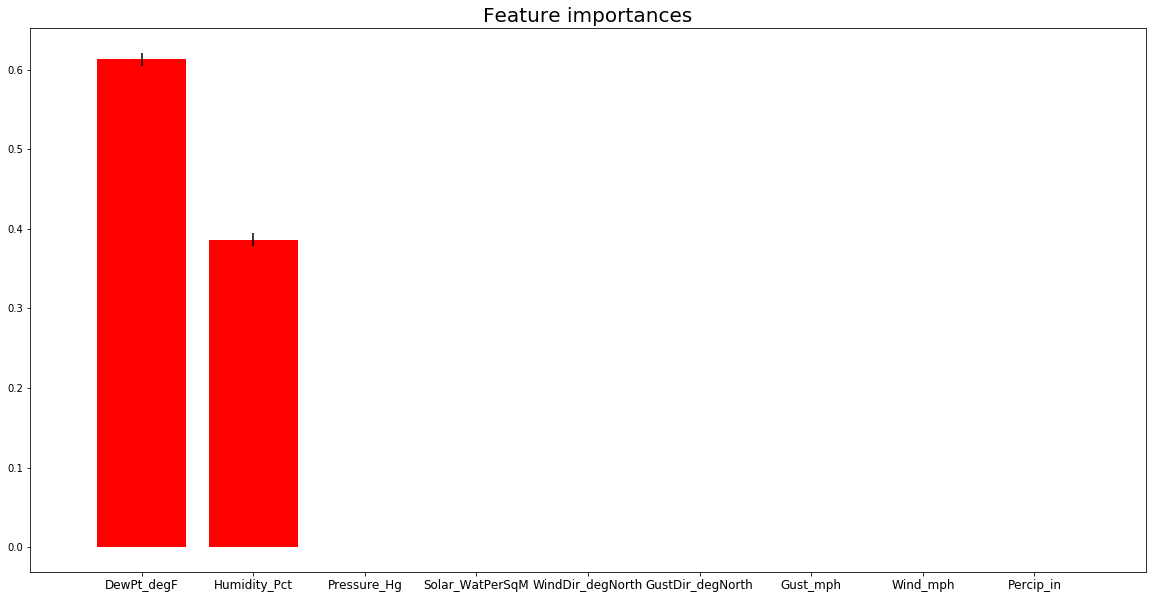

In [130]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
names = X_train.columns.values[indices]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
     print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]) + "(" + names[f] + ")")

# Plot the feature importances of the forest
plt.figure(figsize=(20,10))
plt.title("Feature importances", fontsize = 20)
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), names, fontsize = 12)
plt.xlim([-1, X_train.shape[1]])
plt.show()
